In [ ]:
import h5py
from nexusformat.nexus import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from utils import file_searcher

In [2]:
sample_id = file_searcher("./growths/processes/")
print(sample_id)
print("Total number of files:", len(sample_id))

['4568IGA', '4484IGA', '4685IGA', '4284IGA', '4402IGA', '4736IGA', '4327IGA', '4485IGA', '4712IGA', '4426IGAb', '4586b-IGA', '4532IGA', '4309IGA', '4289IGA', '4435IGA', '4722IGA', '4591IGA', '4585IGA', '4304IGA', '4389IGA', '4320IGA', '4316IGA', '4683IGA', '4723IGA', '4634IGA', '4429IGA', '4544IGA', '4503IGA', '4308IGA', '4407IGA', '4655IGA', '4529IGA-a', '4504IGA', '4477IGA', '4601IGA', '4740IGA', '4281IGA', '4604IGA', '4405IGA', '4587IGA', '4314IGA', '4387IGA', '4527IGA', '4657IGA', '4689IGA', '4295IGA', '4637IGA', '4246IGA', '4558IGA', '4570IGA', '4492IGA', '4566IGA', '4559IGA', '4529IGA', '4318IGA', '4420IGA', '4374IGA', '4526IGA', '4368IGA', '4275IGA', '4633IGA', '4474IGA', '4653IGA', '4238IGA', '4600IGA', '4684IGA', '4242IGA', '4468IGA', '4628IGA', '4313IGA', '4569IGA', '4642IGA', '4279IGA', '4680IGA', '4426IGA', '4312IGA', '4594IGA', '4532IGA-b', '4716IGA', '4291IGA', '4624IGA', '4555IGA', '4598IGA', '4560IGA', '4539IGA', '4588IGA', '4739IGA', '4410IGA', '4377IGA', '4646IGA', '4

In [3]:
file_path = "nexus_file/hm4712IGA.nxs"

In [4]:
# Open your HDF5 file
with h5py.File(file_path, "r") as f:
    def print_h5_structure(name, obj):
        print(name, obj)
    
    f.visititems(print_h5_structure)  # Prints dataset structure

entry <HDF5 group "/entry" (10 members)>
entry/definition <HDF5 dataset "definition": shape (), type "|O">
entry/duration <HDF5 dataset "duration": shape (), type "<f8">
entry/end_time <HDF5 dataset "end_time": shape (), type "|O">
entry/experiment_description <HDF5 dataset "experiment_description": shape (), type "|O">
entry/instrument <HDF5 group "/entry/instrument" (2 members)>
entry/instrument/chamber <HDF5 group "/entry/instrument/chamber" (8 members)>
entry/instrument/chamber/description <HDF5 dataset "description": shape (), type "|O">
entry/instrument/chamber/name <HDF5 dataset "name": shape (), type "|O">
entry/instrument/chamber/sensor_1 <HDF5 group "/entry/instrument/chamber/sensor_1" (3 members)>
entry/instrument/chamber/sensor_1/measurement <HDF5 dataset "measurement": shape (), type "|O">
entry/instrument/chamber/sensor_1/model <HDF5 dataset "model": shape (), type "|O">
entry/instrument/chamber/sensor_1/name <HDF5 dataset "name": shape (), type "|O">
entry/instrument/cha

In [5]:
test = nxload(file_path)
print(test.tree)

root:NXroot
  entry:NXentry
    @default = 'entry'
    definition = 'NXmbe_growth'
    duration = 2.5997222222222223
      @description = 'Total time of growth'
      @units = 'hour'
    end_time = '2024-10-28T13:16:04'
    experiment_description = 'High Mobility Molecular Beam Epitaxy Growth'
      @description = 'Growing technique involved'
    instrument:NXinstrument
      chamber:NXenvironment
        description = ''
          @description = 'Information of the chamber (ex. cooling system)'
        name = 'Built in-house'
          @description = 'Model of the growing chamber'
        sensor_1:NXsensor
          measurement = 'reflectivity'
            @description = 'Physical quantity being measured'
          model = ''
            @description = 'Model of sensor'
          name = 'Reflectometer 950'
            @description = 'Name of sensor'
        sensor_2:NXsensor
          measurement = 'reflectivity'
            @description = 'Physical quantity being measured'
          

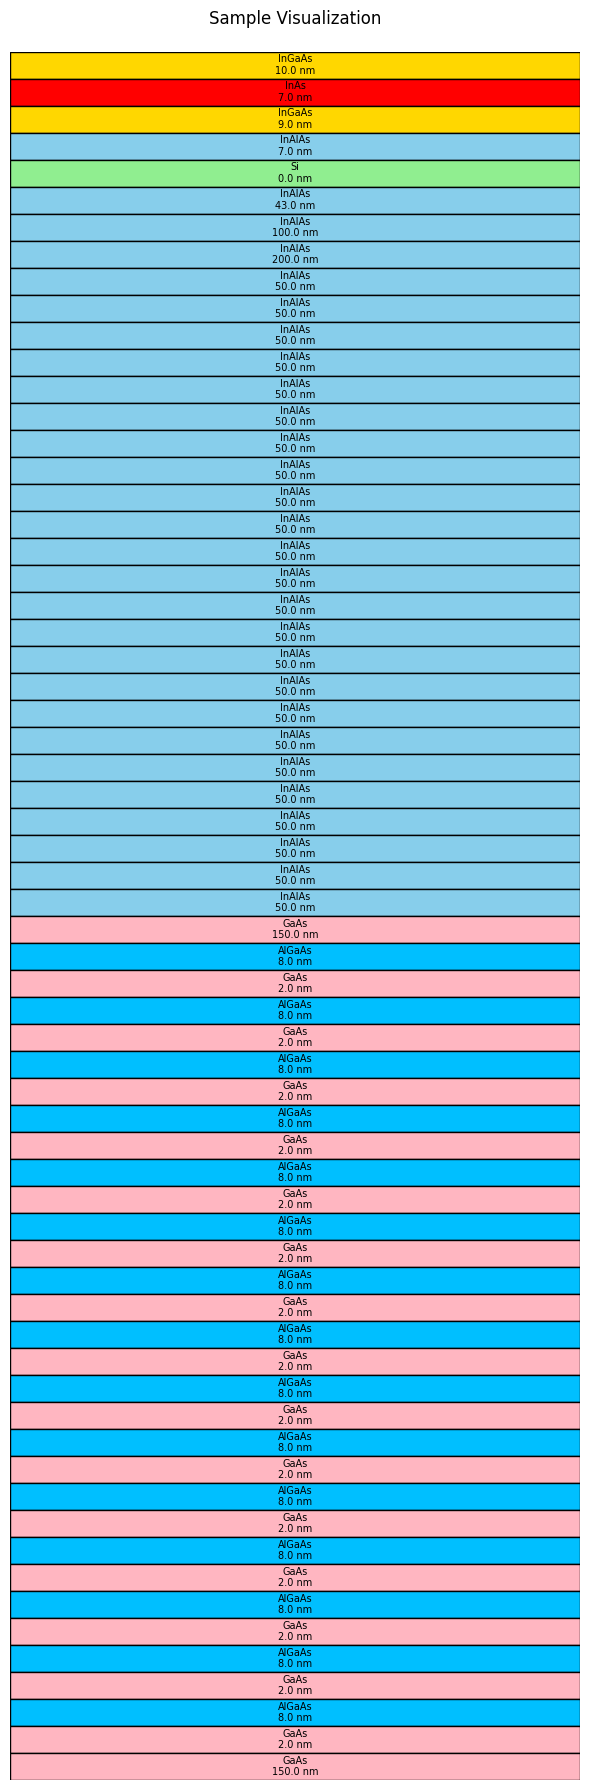

In [8]:
with h5py.File(file_path, 'r') as f:
    sample = f['/entry/sample']
    layer_keys = sorted(
        [k for k in sample.keys() if k.startswith("layer")],
        key=lambda x: int(x.replace("layer", ""))
    )

    layers = []
    for key in layer_keys:
        layer = sample[key]
        thickness = float(layer.get('thickness', [0])[()]) / 10.0  # Å to nm
        formula = layer.get('chemical_formula', b'').asstr()[()] if 'chemical_formula' in layer else 'unknown'
        layers.append((formula, thickness))

# === Draw Equal-Height Stack ===

fig, ax = plt.subplots(figsize=(6, 18))
block_height = 1  
y = 0
total_blocks = len(layers)

color_map = {
    "GaAs": "lightpink",
    "InAs": "red",
    "InAlAs": "skyblue",
    "InGaAs": "gold",
    "AlGaAs": "deepskyblue",
    "Si": "lightgreen",
    "C": "lightgrey"
}

for i, (formula, thickness) in enumerate(reversed(layers)):
    color = color_map.get(formula, "grey")
    rect = patches.Rectangle((0, y), 1, block_height, facecolor=color, edgecolor='k')
    ax.add_patch(rect)

    ax.text(0.5, y + block_height / 2,
            f"{formula}\n{round(thickness, 1)} nm",
            ha='center', va='center', fontsize=7)

    y += block_height

ax.set_xlim(0, 1)
ax.set_ylim(0, total_blocks)
ax.invert_yaxis()
ax.axis('off')
plt.title("Sample Visualization", pad=20)
plt.tight_layout()
plt.show()


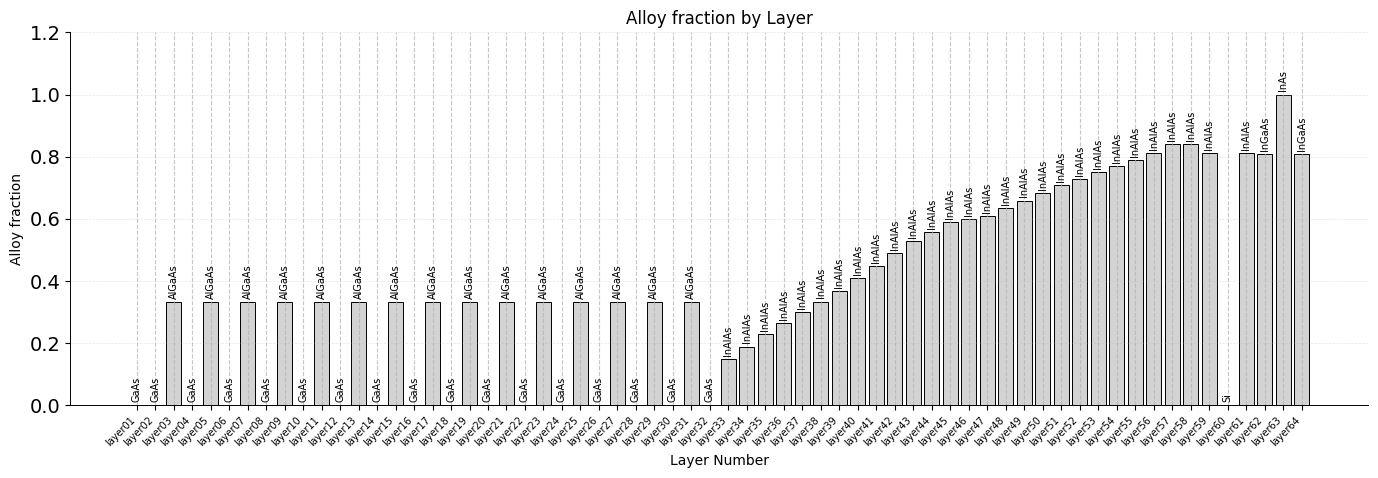

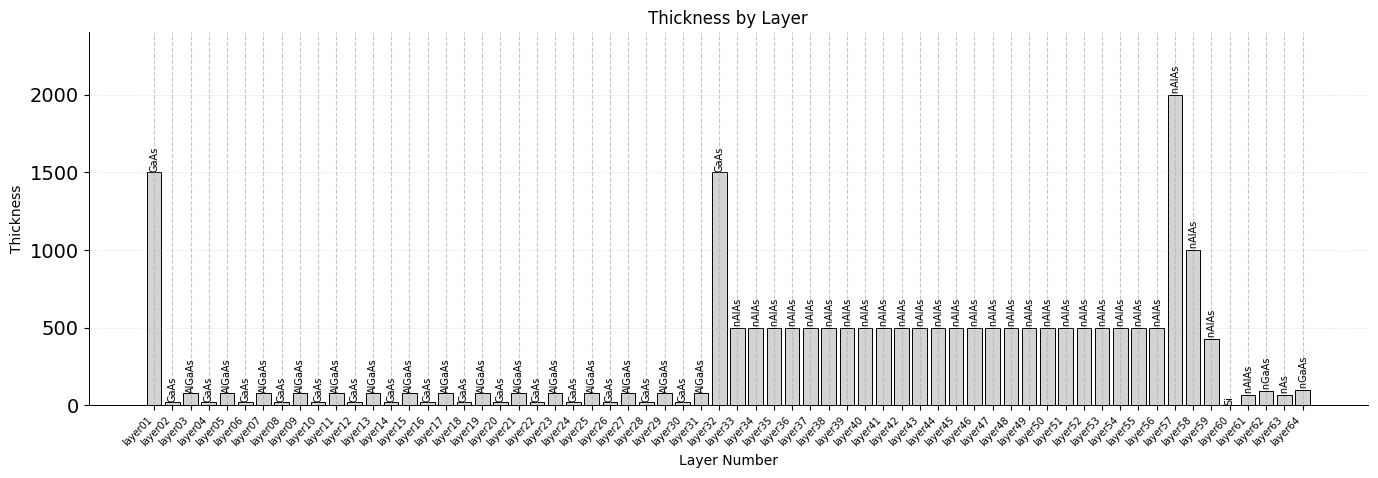

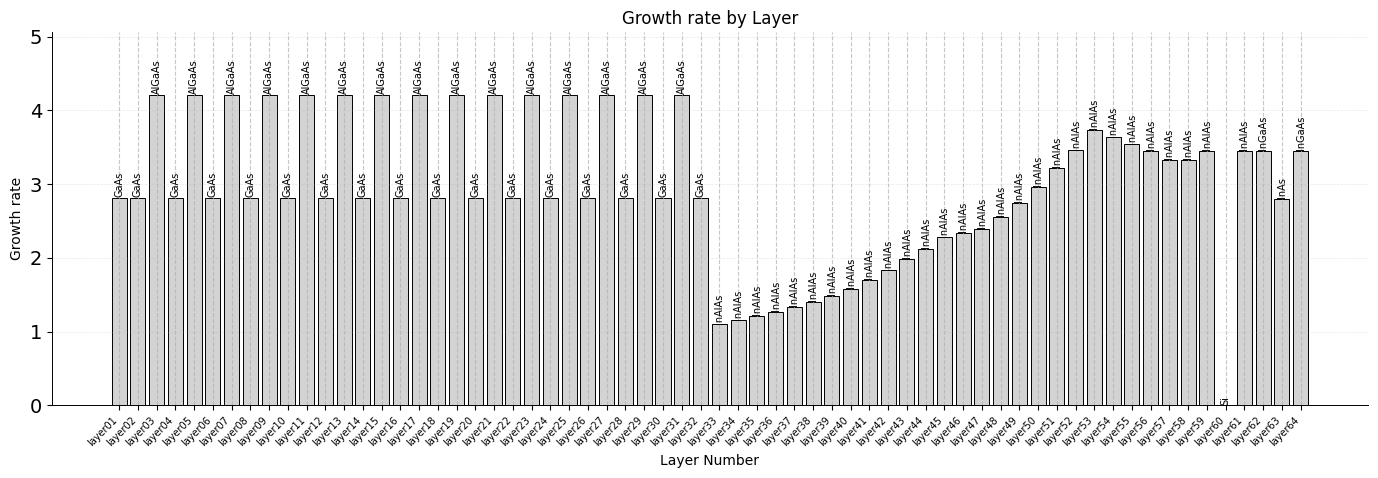

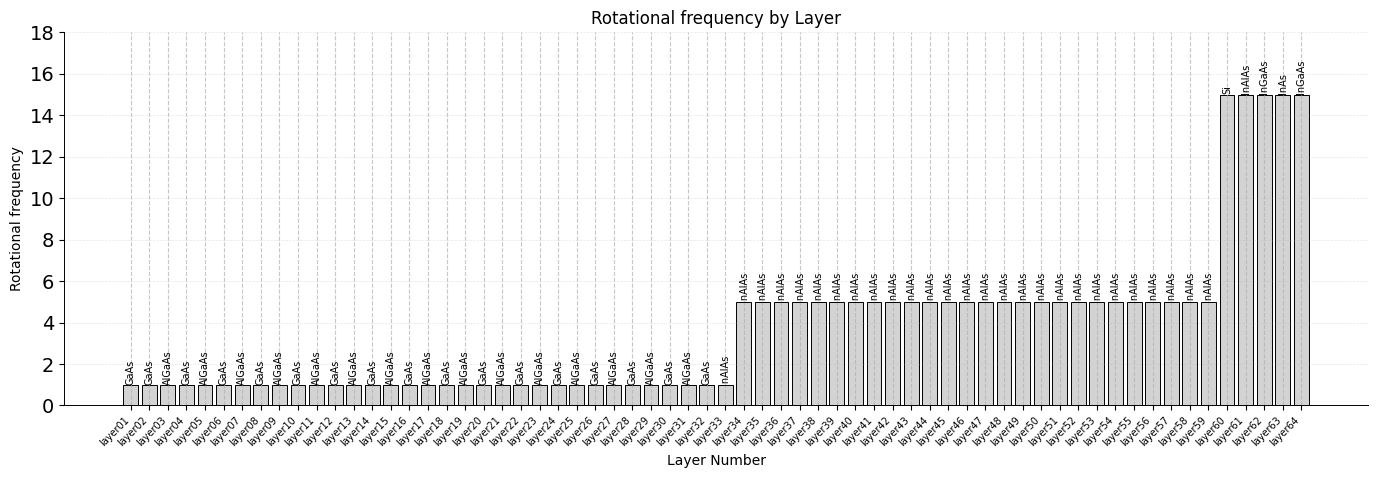

In [ ]:
variables = ["alloy_fraction", "thickness", "growth_rate", "rotational_frequency"]  # Variables to plot

# --- Read all layers ---
with h5py.File(file_path, 'r') as f:
    layer_names = []
    materials = []
    data = {var: [] for var in variables}  # dictionary to store variable values

    for layer_name in f['/entry/sample'].keys():
        if 'layer' in layer_name:
            group = f['/entry/sample'][layer_name]
            layer_names.append(layer_name)
            materials.append(group['chemical_formula'][()].decode())
            for var in variables:
                if var in group:
                    data[var].append(group[var][()])
                else:
                    data[var].append(None)  # handle missing variables

# --- Plot each variable ---
for var in variables:
    y_values = data[var]

    fig, ax = plt.subplots(figsize=(14, 5))
    x = range(len(layer_names))

    bars = ax.bar(x, y_values, color='lightgrey', edgecolor='black', linewidth=0.7)

    ax.set_xlabel('Layer Number', fontsize=10)
    ax.set_ylabel(var.replace('_', ' ').capitalize(), fontsize=10)
    ax.set_title(f'{var.replace("_", " ").capitalize()} by Layer', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(layer_names, rotation=45, ha='right', fontsize=7)

    # Auto-scale Y based on data
    if all(value is not None for value in y_values):
        y_max = max(y_values) * 1.2
        ax.set_ylim(0, y_max if y_max > 0 else 1)
    else:
        ax.set_ylim(0, 1)  # fallback

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.7)
    ax.spines['left'].set_linewidth(0.7)
    ax.grid(axis='y', linestyle='--', alpha=0.3, linewidth=0.5)

    # Annotate each bar with material
    for bar, material in zip(bars, materials):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                material, ha='center', va='bottom', fontsize=7, rotation=90)

    plt.tight_layout()
    plt.show()
